Toan Bui A13599266
<br>
Kaylyn Han
<br>
Elise Wong A13026941

In [1]:
import csv
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import ast
import seaborn as sns
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from numpy import cov
from scipy.stats import pearsonr
from sklearn.utils import shuffle
import numpy as np
from datetime import date

In [2]:
def parseDataFromFile(fname):
  for l in open(fname):
    yield ast.literal_eval(l)
    
beer_dat = list(parseDataFromFile("beer_50000.json"))

In [3]:
beer_dat = pd.DataFrame(beer_dat)

In [4]:
beer_dat = beer_dat.drop(columns=['beer/ABV','beer/beerId','beer/brewerId','beer/name',
'user/ageInSeconds','user/gender','user/profileName','user/birthdayUnix',
'user/birthdayRaw','review/timeUnix', 'review/timeStruct']).dropna() 

## Part 1: Exploratory Analysis on Beer Dataset

In [5]:
beer_dat[:5]

,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text
0,Hefeweizen,2.5,2.0,1.5,1.5,1.5,A lot of foam. But a lot.\tIn the smell some b...
1,English Strong Ale,3.0,2.5,3.0,3.0,3.0,"Dark red color, light beige foam, average.\tIn..."
2,Foreign / Export Stout,3.0,2.5,3.0,3.0,3.0,"Almost totally black. Beige foam, quite compac..."
3,German Pilsener,3.5,3.0,3.0,2.5,3.0,"Golden yellow color. White, compact foam, quit..."
4,American Double / Imperial IPA,4.0,4.5,4.0,4.0,4.5,"According to the website, the style for the Ca..."


In [6]:
print("The beer-review dataset contains " + str(len(beer_dat['beer/style'].unique())) + " unique types of beer\n")
print("Here are 5 most-reviewed types of beer: ")
top_5_beer = beer_dat['beer/style'].value_counts().head(5).to_frame() 
top_5_beer.columns = ['NUMBER OF REVIEWS']
top_5_beer

The beer-review dataset contains 95 unique types of beer

Here are 5 most-reviewed types of beer: 


,NUMBER OF REVIEWS
American Double / Imperial Stout,5964
American IPA,4113
American Double / Imperial IPA,3886
Scotch Ale / Wee Heavy,2776
Russian Imperial Stout,2695


In [7]:
to_contain = 'American Double / Imperial Stout|American IPA|American Double / Imperial IPA|Scotch Ale / Wee Heavy|Russian Imperial Stout'
df_top_5 = beer_dat[beer_dat['beer/style'].str.contains(to_contain , na=False)]

In [8]:
df_top_5 = df_top_5.sort_values(by=['beer/style']) 
df_top_5 = df_top_5.reset_index() 
df_top_5.drop('index', axis=1, inplace=True)

beer_styles = ['American Double / Imperial Stout', 'American IPA', 'American Double / Imperial IPA','Scotch Ale / Wee Heavy','Russian Imperial Stout']
beer_ratings = [0,0,0,0,0]
appearance_rating_dict = dict(zip(beer_styles,beer_ratings)) 
palate_rating_dict = dict(zip(beer_styles,beer_ratings)) 
aroma_rating_dict = dict(zip(beer_styles,beer_ratings)) 
taste_rating_dict = dict(zip(beer_styles,beer_ratings)) 
overall_rating_dict = dict(zip(beer_styles,beer_ratings))

for style in beer_styles:
    appearance_rating_dict[style] = round(df_top_5[df_top_5['beer/style'] == style]['review/appearance'].mean(),2) 
    palate_rating_dict[style] = round(df_top_5[df_top_5['beer/style']== style]['review/palate'].mean(),2)
    aroma_rating_dict[style] = round(df_top_5[df_top_5['beer/style'] == style]['review/aroma'].mean(),2)
    taste_rating_dict[style] = round(df_top_5[df_top_5['beer/style'] == style]['review/taste'].mean(),2)
    overall_rating_dict[style] = round(df_top_5[df_top_5['beer/style']== style]['review/overall'].mean(),2)
    
appearance_rating_df = pd.Series(appearance_rating_dict).to_frame() 
palate_rating_df = pd.Series(palate_rating_dict).to_frame() 
aroma_rating_df = pd.Series(aroma_rating_dict).to_frame() 
taste_rating_df = pd.Series(taste_rating_dict).to_frame() 
overall_rating_df = pd.Series(overall_rating_dict).to_frame()

In [9]:
appearance_rating_df.columns = ['Appearance Rating'] 
palate_rating_df.columns = ['Palate Rating'] 
aroma_rating_df.columns = ['Aroma Rating'] 
taste_rating_df.columns = ['Taste Rating'] 
overall_rating_df.columns = ['Overall Rating']

ratings_df = pd.concat([appearance_rating_df, palate_rating_df], axis= 1, join='inner')
ratings_df = pd.concat([ratings_df, aroma_rating_df], axis=1, join='inner')
ratings_df = pd.concat([ratings_df, taste_rating_df], axis=1, join='inner')
ratings_df = pd.concat([ratings_df, overall_rating_df], axis=1, join='inner')

print("\nAn Overview of the Ratings for the 5 Most-reviewed Beer Types ")
#The dataframe that contains all the individual ratings ratings_df ## THIS CONTAINS THE AVERAGE RATINGS

ratings_df


An Overview of the Ratings for the 5 Most-reviewed Beer Types 


,Appearance Rating,Palate Rating,Aroma Rating,Taste Rating,Overall Rating
American Double / Imperial Stout,4.32,4.35,4.41,4.48,4.33
American IPA,3.98,3.92,3.97,4.00,4.04
American Double / Imperial IPA,3.99,3.98,4.07,4.03,3.87
Scotch Ale / Wee Heavy,3.92,3.96,4.00,4.08,3.92
Russian Imperial Stout,4.21,4.29,4.17,4.30,4.16


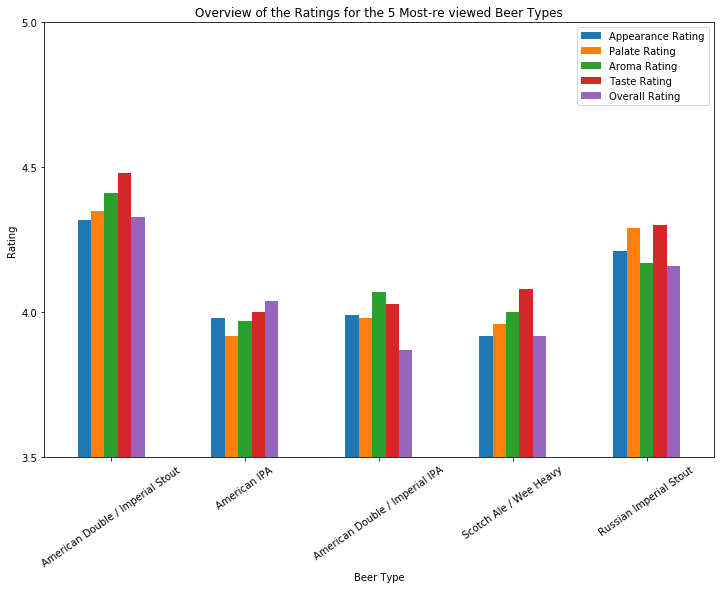

In [10]:
ratings_df.plot.bar(title = 'Overview of the Ratings for the 5 Most-re viewed Beer Types',figsize= (12,8))
labels = [3.5, 4.0, 4.5, 5.0]
plt.yticks(labels)
plt.ylim(3.5,5) 
plt.xticks(rotation = 35) 
plt.xlabel("Beer Type") 
plt.ylabel("Rating") 
plt.show()

## Observation:
From the bar chart above, we can see that "American Double/Imperial Stout" is the beer type that receives the highest review in all categories (appearance, palate, aroma, taste and overall)

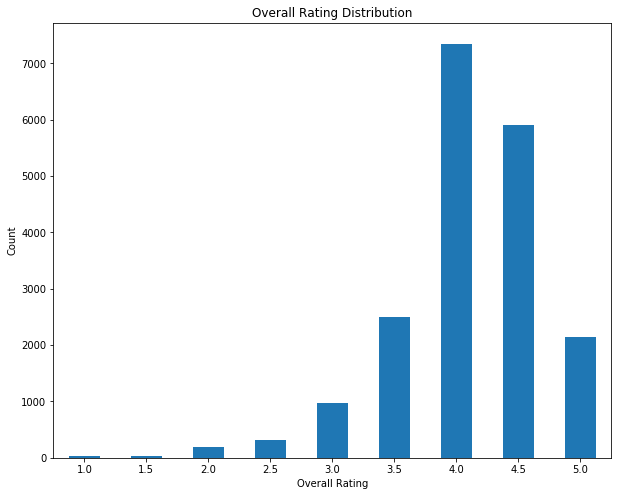

In [11]:
df_top_5['review/overall'].value_counts().sort_index().plot('bar',title = 'Overall Rating Distribution',figsize= (10,8))
plt.xticks(rotation = 0)
plt.xlabel("Overall Rating")
plt.ylabel("Count") 
plt.show()

## Observation:
From the bar chart above, we can see that people tend to give an overall rating of 4.0 for the 5 most-popular beer styles. This means that the most-reviewed beers also tend to receive a relatively high overall rating.

In [12]:
df_top_5 = df_top_5.drop(columns=['review/text'])
df_top_5.columns = ['Style', 'Appearance', 'Aroma', 'OVERALL', 'Palate', 'Taste']
df_top_5 = df_top_5[['Style', 'Appearance', 'Aroma','Palate', 'Taste', 'OVERALL', ]]
data = df_top_5.sample(frac=1) ## random shuffle the dataframe ( not in place)

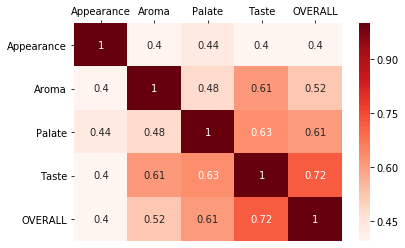

In [13]:
#Using Pearson Correlation plt.figure(figsize=(10,10))
cor = data.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) 
ax.xaxis.set_ticks_position('top')
loc, labels = plt.yticks() 
ax.set_yticklabels(labels, rotation=0)
plt.show()

## OBSERVATION:
Based on the correlation matrix above, we can see that taste correlates the most (corr = 0.72) with the overall beer rating, meaning that taste is the most important feature of a beer.

## Part 2: Predictive Task

### Predicting Overall Beer Rating from Taste, Appearance, Aroma and Palate Ratings

- Data is split into train and test set (80:20 ratio)

- Using the ratings for the four features (taste, appearance, aroma and palate), we will use first use linear regression to predict the overall rating for each beer style. This will serve as the baseline predictor that we will improve upon

In [14]:
def pick_feature(datum): 
    feat=[]
    feat.append( datum['Taste']) 
    feat.append( datum['Appearance']) 
    feat.append( datum['Aroma']) 
    feat.append( datum['Palate']) 
    return feat

In [15]:
x = [] 
y = []
for index, row in data.iterrows():
    x.append(pick_feature(row))
    y.append(row['OVERALL'])

In [16]:
#train-test split
test_size = int(len(x)*float(0.2))
train_size = int(len(x)*float(0.8))
                 
trainX = x[ :train_size] 
trainY = y[ :train_size] 

testX = x[-test_size:] 
testY = y[-test_size:]                 

In [17]:
model = LinearRegression()
model.fit(trainX, trainY)
pred = model.predict(testX)

In [18]:
#Returns the coefficient of determination R^2 of the prediction.
model.score(trainX, trainY)

0.5695356797771902

In [19]:
#after predicting the overall beer rating, decide a threshold to calculate accuracy of beer prediction
# ?!!!!!!!!
# smaller than THRESHOLD === accurate prediction
# for now, set threshold to be 0.4, given ratings range from 0 - 5

threshold = 0.4
diff = abs(testY - pred)
sum(diff <= threshold)/len(diff)

0.7287699433865157

In [20]:
diff

array([0.03411957, 0.26234221, 0.10617804, ..., 0.27871195, 0.51540076,
       0.56405856])